- Construir una matriz INPUTS 150 x 4
- Crear una matriz OUTPUT 150 x 1
- Crear variable numEjemplos (size) (150)
- Crear variable numClases (unique(OUTPUT)) (3)
- Guardar las 4 variables 'iris'

In [386]:
import pandas as pd
import os
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle
from scipy import stats
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
from sklearn.metrics import roc_curve

## Cargamos Dataset

In [387]:
# Cargamos dataset iris
iris = pd.read_csv('iris.data', header=None, names=['largo_sepalo','ancho_sepalo','largo_petalo','ancho_petalo','clase'])

In [388]:
y = iris.clase.values
X = iris.drop('clase',axis=1).values

In [389]:
bcw = pd.read_csv('./breast-cancer-wisconsin.data', header=None)

## Detección de Outliers

In [390]:
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)

In [391]:
y_pred = clf.fit_predict(X)

In [392]:
X_scores = clf.negative_outlier_factor_

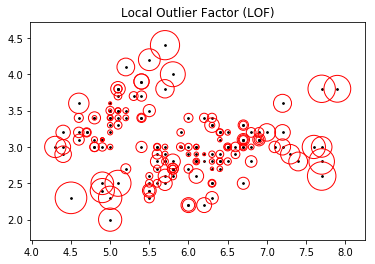

In [393]:
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color='k', s=3., label='Data points')
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(X[:, 0], X[:, 1], s=1000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')
plt.show()

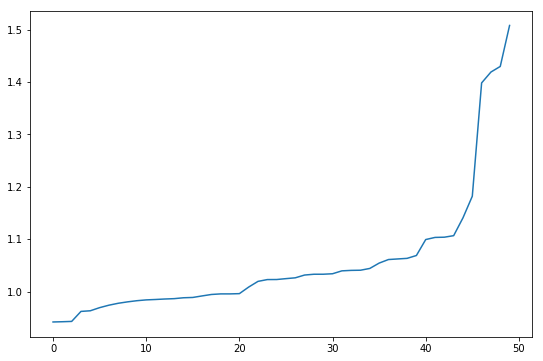

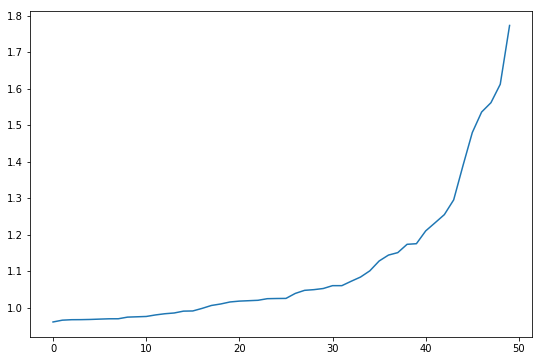

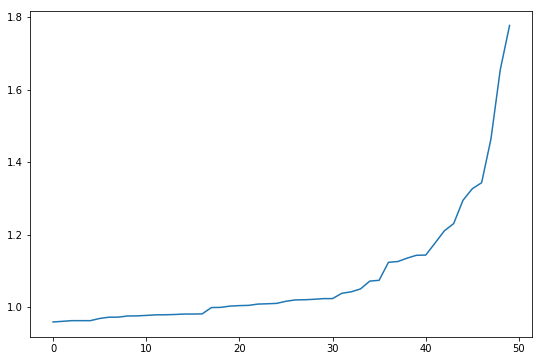

In [394]:
for i in set(y):
    # Create a figure instance
    fig = plt.figure(figsize=(9, 6))

    # Create an axes instance
    ax = fig.add_subplot(111)
    temp = X[y == i]
    y_pred = clf.fit_predict(temp)
    temp_scores = clf.negative_outlier_factor_
    ax.plot(range(len(temp_scores)),sorted(-temp_scores))

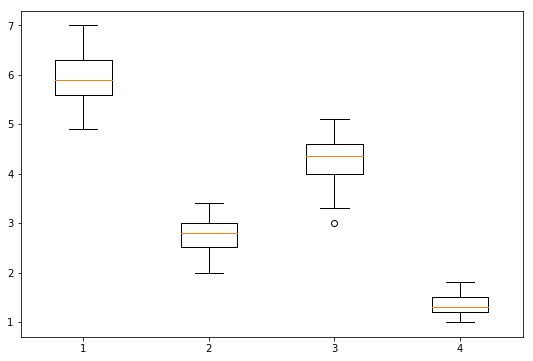

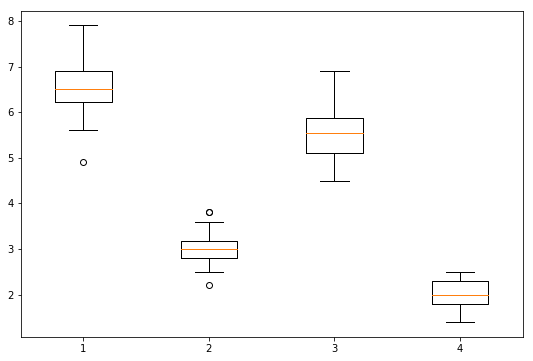

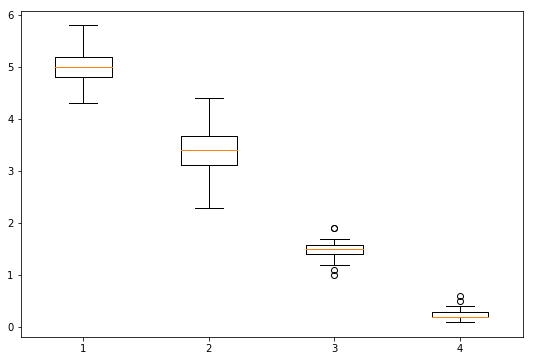

In [395]:
# X[y == 'Iris-versicolor']
for i in set(y):
    # Create a figure instance
    fig = plt.figure(figsize=(9, 6))

    # Create an axes instance
    ax = fig.add_subplot(111)
    temp = X[y == i]
    data = []
    for j in range(X.shape[1]):
        data.append(temp[:,j])
    bp = ax.boxplot(data)
#         print(temp[:,j])
plt.show()

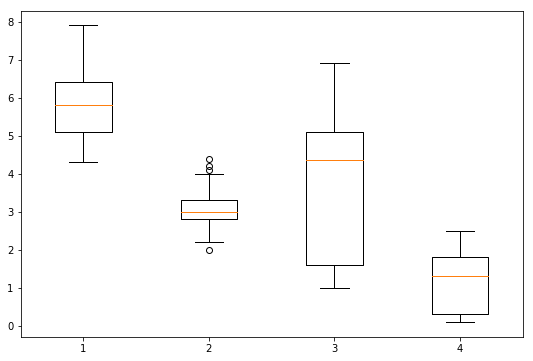

In [396]:
# Create a figure instance
fig = plt.figure(figsize=(9, 6))
# Create an axes instance
ax = fig.add_subplot(111)
data = []
for j in range(X.shape[1]):
    data.append(X[:,j])
bp = ax.boxplot(data)
plt.show()

## Preprocesado de datos

**Comprobamos que no haya "missing values"**  
Dado que no los hay, seguimos adelante.

In [397]:
attr = []
# Iteramos los atributos del dataset
for i in iris.columns:
    # Comprobamos los valores de cada atributo
    attr.append(np.all(iris[i].notna()))
# Ningún atributo tiene missing values:
np.all(np.array(attr))

True

**Comprobamos que no haya variables con "near-zero variance"**  
Vemos que no hay ninguna.

In [398]:
iris.columns.drop('clase')[iris.std() < 0.001]

Index([], dtype='object')

**Comprobamos que no haya variables iguales**  
Vemos que no hay ninguna.

In [399]:
resultados = np.zeros((len(iris.columns), len(iris.columns)))
for i in range(len(iris.columns)):
    for j in range(len(iris.columns)):
        resultados[i, j] = np.mean(iris.iloc[:, i] == iris.iloc[:, j])

In [400]:
iguales = []
for i, j in it.combinations(range(len(iris.columns)), 2):
    if round(resultados[i, j], 4) == 1:
        iguales.append(iris.columns[i])
        print(iris.columns[i], iris.columns[j])

**Comprobamos que las clases no estén desbalanceadas**  


In [401]:
y = np.array([i for i,j in enumerate(set(y)) for k in y if j == k])

In [402]:
print('Proporción clase 0: ',np.mean(y==0))
print('Proporción clase 1: ',np.mean(y==1))
print('Proporción clase 2: ',np.mean(y==2))

Proporción clase 0:  0.3333333333333333
Proporción clase 1:  0.3333333333333333
Proporción clase 2:  0.3333333333333333


**Desordenamos los datos**

In [403]:
X,y = shuffle(X,y)

## Entrenamiento de Modelos

**Hold Out**

In [404]:
def performance_indexes(CM, PositiveClass):
    classNum = len(CM)
    TP = CM[PositiveClass, PositiveClass]
    TN = 0
    FP = 0
    FN = 0
    for real in range(classNum):
        for predicted in range(classNum):
            if (real != PositiveClass and predicted != PositiveClass):
                TN += CM[real, predicted]
            if (real != PositiveClass and predicted == PositiveClass):
                FP += CM[real, predicted]
            if (real != PositiveClass and predicted == PositiveClass):
                FN += CM[real, predicted]
    Sens = TP/(TP+FN)
    Spec = TN/(TN+FP)
    PPV = TP/(TP+FP)
    NPV = TN/(TN+FN)
    ACC = (TP+TN)/(TP+TN+FP+FN)
    return Sens,Spec,PPV,NPV,ACC

In [405]:
# CM = confusion_matrix(y_test, y_pred)
# Sens,Spec,PPV,NPV,ACC = performance_indexes(CM,1)
# print('Sens: {:.4f}, Spec: {:.4f}, PPV: {:.4f}, NPV: {:.4f}, ACC: {:.4f}'.format(Sens,Spec,PPV,NPV,ACC))

**kFold - Linear Discriminant Analysis**

In [406]:
kf = KFold(n_splits=10)
resultados_train = []
resultados_test = []
for tipo in ('lsqr', 'eigen', 'svd'):
    for _ in range(3):
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            alg = LinearDiscriminantAnalysis(solver=tipo, shrinkage=None)
            alg.fit(X_train, y_train)
            resultados_train.append(alg.score(X_train, y_train))
            resultados_test.append(alg.score(X_test, y_test))
resultados_train = np.reshape(resultados_train,(30,3),order='F')
resultados_test = np.reshape(resultados_test,(30,3),order='F')

**Test de normalidad**  
Rechazamos normalidad

In [407]:
print(stats.shapiro(resultados_test[:,0])[1])
print(stats.shapiro(resultados_test[:,1])[1])
print(stats.shapiro(resultados_test[:,2])[1])

3.9143813523878634e-08
3.9143813523878634e-08
3.9143813523878634e-08


**Test de Kruskal-Wallis**  
No se puede rechazar que las precisiones sean similares

In [408]:
print(stats.kruskal(resultados_test[:,0],resultados_test[:,1],resultados_test[:,2]))

KruskalResult(statistic=0.0, pvalue=1.0)


**kFold - Quadratic Discriminant Analysis**

In [409]:
kf = KFold(n_splits=10)
resultados_trainq = []
resultados_testq = []
for _ in range(3):
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        alg = QuadraticDiscriminantAnalysis(priors=np.array([1/3, 1/3, 1/3]))
        alg.fit(X_train, y_train)
        # print(classification_report(y_true, y_pred, target_names=target_names))
        resultados_trainq.append(alg.score(X_train, y_train))
        resultados_testq.append(alg.score(X_test, y_test))
# resultados_train = np.reshape(resultados_train,(10,3),order='F')
# resultados_test = np.reshape(resultados_test,(10,3),order='F')

**Test de normalidad**  
Rechazamos normalidad

In [410]:
print(stats.shapiro(resultados_testq)[1])

1.8855885173252318e-06


**Test de Kruskal-Wallis**  
No se puede rechazar que las precisiones sean similares

In [411]:
#TODO: renombrar variables mejor
print(stats.kruskal(resultados_test[:,0],resultados_test[:,1],resultados_test[:,2], resultados_testq))

KruskalResult(statistic=1.6999999999999527, pvalue=0.6369337956527499)


**Tukey**

In [55]:
tukey01 = pairwise_tukeyhsd(y_pred,y_test)
# tukey02 = pairwise_tukeyhsd(resultados_test[:,0],resultados_test[:,2])
# tukey12 = pairwise_tukeyhsd(resultados_test[:,1],resultados_test[:,2])
print(tukey01)
# print(tukey02)
# print(tukey12)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower upper reject
-----------------------------------------
  0      1      1.0     1.0   1.0   True 
  0      2      2.0     2.0   2.0   True 
  1      2      1.0     1.0   1.0   True 
-----------------------------------------


In [32]:
# MultiComp = MultiComparison(stacked_data['result'],
#                             stacked_data['treatment'])
# print(MultiComp.tukeyhsd().summary())


**----------------------------------------------------------------------------------------------------------------------------**

## Persistencia

In [35]:
# with open('RForest_Zika_oversampled.bin','wb') as file:
#     pickle.dump(alg_o, file)
# with open('RForest_Zika_undersampled.bin','wb') as file:
#     pickle.dump(alg_u, file)

## FIN